In [1]:
# default_exp app

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# app

In [2]:
import sys
sys.path.append('..')

In [3]:
from code.datasource import SinaDataSource, etf_dict
from code.visualization import draw_charts, gen_chart_data
import pandas as pd
from mylib.algo.ml.tree.catboost import train_val, predict, val
from sklearn.model_selection import train_test_split

# app

In [4]:
import panel as pn
pn.extension()

In [5]:
label_col = [
            'label_10',
            'label_10_',
        #     label label1  label_1 label_0
        ]
cols = []

In [6]:
x = pn.widgets.Select(name='标的', options=list(etf_dict.keys()))
y = pn.widgets.Select(name='label', options=label_col)
threshold = pn.widgets.Select(name='threshold', options=[0.2, 0.1, 0.15, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6])
threshold2 = pn.widgets.Select(name='threshold2', options=[0.2, 0.1, 0.15, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6])
static_text = pn.widgets.StaticText(name='预测起始日期',
                                    value='000000')

In [7]:
ds_dict = {}
model_dict = {}
val_date_dict = {}

In [8]:
ds_dict

{}

In [9]:
model_dict

{}

In [10]:
val_date_dict

{}

In [11]:
cols

[]

In [12]:
@pn.depends(x.param.value, y.param.value, threshold.param.value, threshold2.param.value)
def ft(x, y, threshold, threshold2):
    global cols
    if x not in ds_dict:
        ds = SinaDataSource(x, '20100101')
        ds_dict[x] = ds
        
        _tmp = ds.data.copy()
        n = 10
        _tmp[f'label_{n}'] = 0
        _tmp[f'label_{n}_'] = 0

        def t(s):
            return s.max()/s.iloc[0]-1
        _tmp['t'] = _tmp['close'].rolling(n).agg(t)
        _tmp.loc[_tmp[f't'] >= 0.05, f'label_{n}'] = 1
        
        def t(s):
            return s.min()/s.iloc[0]-1
        _tmp['t'] = _tmp['close'].rolling(n).agg(t)
        _tmp.loc[_tmp[f't'] <= -0.05, f'label_{n}_'] = 1
        
        _tmp[f'label_{n}'] = _tmp[f'label_{n}'].shift(-n)
        _tmp[f'label_{n}_'] = _tmp[f'label_{n}_'].shift(-n)

        _tmp = _tmp.dropna()
        del _tmp['t']
        
        cols = _tmp.drop(columns=label_col+'volume_pct close_pct open high low close volume'.split()).columns
        X_train, X_test, y_train, y_test = train_test_split(_tmp[cols], _tmp[y], test_size=0.1, 
                                                        shuffle=False)
        val_date = y_test.index.map(str).tolist()[0]
        val_date_dict[x] =  val_date
        model1, _, _ = train_val(X_train, y_train, valset=(X_test, y_test), plot=True, threshold=threshold)
        
        model_dict[f'{x}_{y}'] = model1
        
        X_train, X_test, y_train, y_test = train_test_split(_tmp[cols], _tmp[f'{y}_'], test_size=0.1, 
                                                        shuffle=False)
        model2, _, _ = train_val(X_train, y_train, valset=(X_test, y_test), plot=True, threshold=threshold2)
        model_dict[f'{x}_{y}_'] = model2
        
    else:
        ds = ds_dict[x]
        model1 = model_dict[f'{x}_{y}']
        model2 = model_dict[f'{x}_{y}_']
        val_date = val_date_dict[x]
#         if y=='label_10':
    static_text.value = val_date
    dfr = predict(model1, ds.data[cols], [], threshold=threshold)
    ds.data['predict_label_1'] = dfr.predict_label
    ds.data['score'] = dfr.score
    dft = ds.data.reset_index()
    ix = dft[dft.predict_label_1==1].index.tolist()
    score = dft[dft.predict_label_1==1].score.tolist()
    markpoints1 = list(zip(ix, score))
    dfr = predict(model2, ds.data[cols], [], threshold=threshold2)
    ds.data['predict_label_1'] = dfr.predict_label
    ds.data['score'] = dfr.score
    dft = ds.data.reset_index()
    ix = dft[dft.predict_label_1==1].index.tolist()
    score = dft[dft.predict_label_1==1].score.tolist()
    markpoints2 = list(zip(ix, score))
#     markpoints2 = ds.data.reset_index()[ds.data.reset_index().predict_label_1==1].index.tolist()
    return draw_charts(gen_chart_data(ds.data), x, markpoints1, markpoints2)

3861
code:sh000001, start_date: 20100101, end_date: 20200728, datalen: 3861
               open     high      low    close       volume
day                                                        
2010-01-04  3289.75  3295.28  3243.32  3243.76  1.09448e+10
2010-01-05  3254.47  3290.51  3221.46  3282.18  1.26115e+10
               open     high      low    close       volume
day                                                        
2020-07-27  3210.39  3221.99  3174.66  3205.23  2.99319e+10
2020-07-28  3226.13   3245.3  3208.49  3227.96  2.89378e+10
{'iterations': 500, 'learning_rate': 0.05, 'random_seed': 144, 'custom_metric': 'F1', 'loss_function': 'Logloss'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

../mylib/algo/ml/tree/catboost.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fea_ = df_features_importance.sort_values('value')[df_features_importance.value > 0].value
../mylib/algo/ml/tree/catboost.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fea_name = df_features_importance.sort_values('value')[df_features_importance.value > 0].name


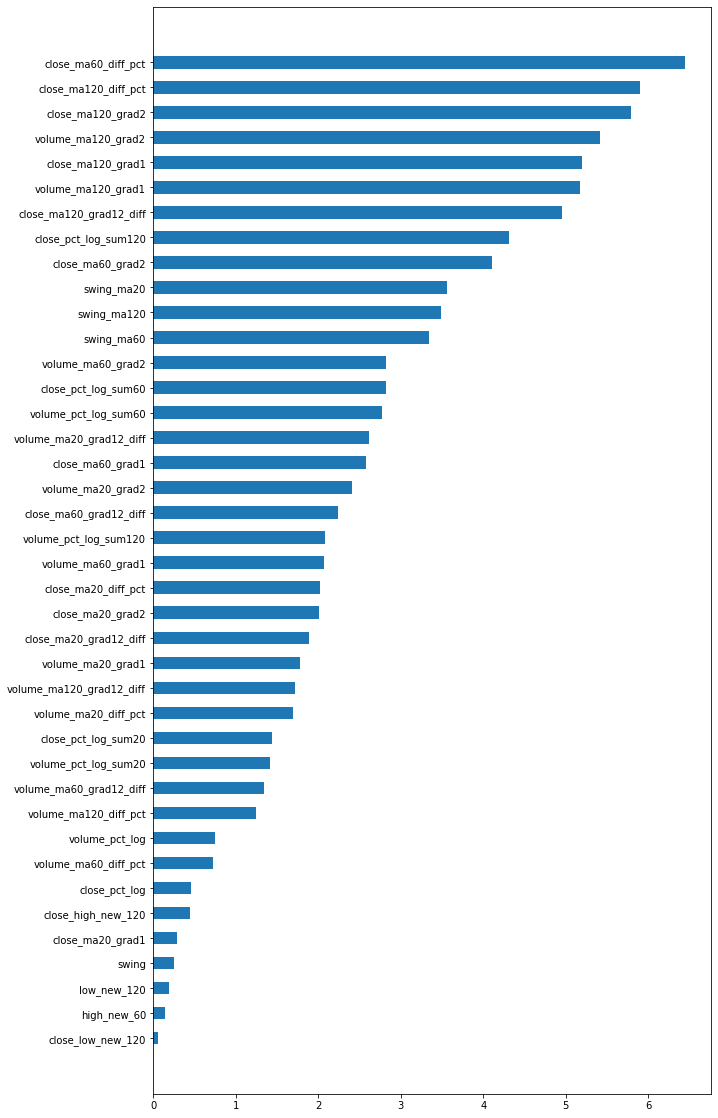

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       225
         1.0       0.20      0.05      0.08        19

    accuracy                           0.91       244
   macro avg       0.56      0.52      0.52       244
weighted avg       0.87      0.91      0.88       244

0    239
1      5
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2020-07-06         0.0  0.228479              1      1
2020-02-03         1.0  0.222424              1      2
2020-07-08         0.0  0.207698              1      3
2020-07-14         0.0  0.206079              1      4
2020-07-10         0.0  0.202899              1      5
2020-02-04         1.0  0.139126              0     12
2020-07-02         1.0  0.121448              0     18
2020-02-07         1.0  0.117888              0     20
2020-02-06         1.0  0.096328              0     43
2020-02-27      

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

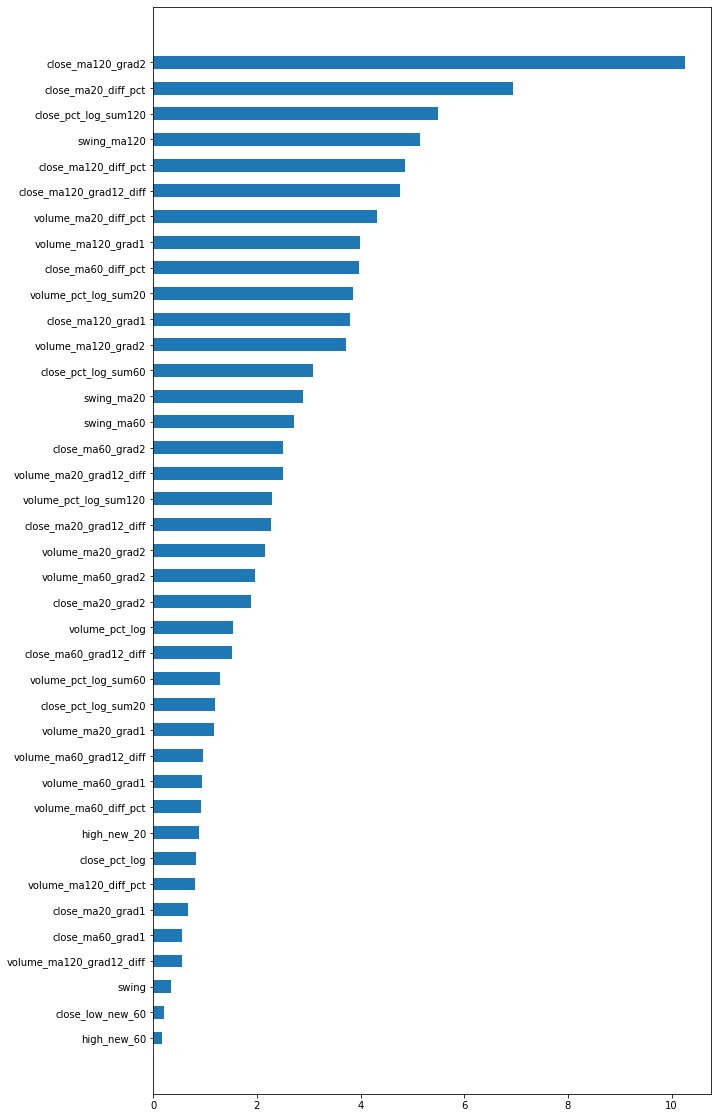

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       215
         1.0       0.00      0.00      0.00        29

    accuracy                           0.86       244
   macro avg       0.44      0.49      0.46       244
weighted avg       0.77      0.86      0.82       244

0    239
1      5
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2019-09-24         0.0  0.228463              1      1
2019-09-27         0.0  0.228362              1      2
2019-10-08         0.0  0.220250              1      3
2019-07-15         0.0  0.218585              1      4
2019-09-30         0.0  0.201982              1      5
2019-07-30         1.0  0.179534              0     15
2019-07-24         1.0  0.172969              0     18
2019-07-25         1.0  0.155317              0     31
2019-07-26         1.0  0.152664              0     33
2019-07-29      

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/composite_charts/grid.py:17: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [13]:
c = pn.Column(
    '# stock',
    pn.Row(x, y),
    pn.Row(threshold, threshold2),
    static_text,
    ft
)

大盘: 0.3 0.2

上证50 0.2 0.25 买点都是雷，卖点很准！

hs300 0.15 0.3

军工 0.3， 0.35

证券 0.4 0.6



银行ETF 0.2 0.3

环保 0.35 0.6

消费 0.3 0.45

In [14]:
c

Column
    [0] Markdown(str)
    [1] Row
        [0] Select(name='标的', options=['大盘', '上证50', ...], value='大盘')
        [1] Select(name='label', options=['label_10', 'label_10_'], value='label_10')
    [2] Row
        [0] Select(name='threshold', options=[0.2, 0.1, 0.15, ...], value=0.2)
        [1] Select(name='threshold2', options=[0.2, 0.1, 0.15, ...], value=0.2)
    [3] StaticText(name='预测起始日期', value='2019-07-12 00:00:00')
    [4] ParamFunction(function)

# nbexport

In [55]:
from nbdev.export import *
notebook2script('1profile.ipynb')

Converted datasource.ipynb.


# zqb

In [796]:
!pip install baostock

     |████████████████████████████████| 61kB 399kB/s eta 0:00:01


In [797]:
import baostock as bs
import pandas as pd

# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

login success!
login respond error_code:0
login respond  error_msg:success


In [802]:
# 详细指标参数，参见“历史行情指标参数”章节
rs = bs.query_history_k_data_plus("sh.510050",
    "date,code,open,high,low,close,preclose,volume,amount,pctChg",
    start_date='2017-01-01', end_date='2017-06-30', frequency="d")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success


In [799]:
rs

In [803]:
# 打印结果集
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

In [804]:
result.head()

Empty DataFrame
Columns: [date, code, open, high, low, close, preclose, volume, amount, pctChg]
Index: []

In [ ]:
https://zhuanlan.zhihu.com/p/54299970